# Practical Bin Packing 
This was motivated by a desire to buy just enough materials to get the job done.   In this case the job was a chicken coop I was building.  I can buy lumber in standard lengths of 12, 10, 8 or 6 feet at my local building supply store.   So what is the lowest cost combination of stock boards that fills the need?

In my research I found lots of examples of bin packing with a single size of bin but nothing that fit my situation and limited appetite for in depth study. 
This code uses a brute force approach to the problem.  It enumerates all permutations, discards any that don't meet the bare minimum length then checks each remaining permutation for feasilbility.  The feasible options are sorted to find the minmum cost option.   

In the example below, I first define the **stock** lengths and their **rates**.  Then I list the **parts** needed for the project.  The part lengths are listed as integers but could just as well have been floats. 

In [11]:
import itertools as it
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

stock = np.array([144, 120, 96])  # 12', 10' and 8' lengths
rates = np.array([9.17, 8.51, 7.52 ])  # costs for each length (1x4)
parts = [84, 72, 54, 36, 30, 30, 24, 24]   #  list of pieces needed (1x4)
minlength = sum(parts)

Then I use a method from Python's itertools module to generate the cartesian product (permuations with repitition). The input to the itertools.product function includes a list of choices for each item.   Depending on the size of your problem you might need to extend the list to find the optimal solution.    

In [12]:
combos = it.product([0,1,2,3,4,5,6], repeat=len(stock)) 
candidates = []
cost = [] 
valid = [] 

# Discard combos that dont have the minimum length required
for item in combos:
    x = list(item)
    length = np.dot(x,stock)
    if length >= minlength:
        candidates.append(x)
        cost.append(np.dot(x,rates))
        valid.append(False)

print [candidates[i] for i in [0, 20, 40, 60]]

[[0, 0, 4], [0, 4, 1], [1, 0, 3], [1, 3, 3]]


I've printed a few samples of candidates that meet the minimum length criteria.  I could also have thrown out candidates that have way too much length since they aren't likely to be cost effective.  Each candidate is a list of quantities corresponding to stock sizes.  For the example, if a candidiate equals [0, 0, 4], it has no 12' lengths, no 10' lengths and four 8' lengths. 

The code uses a method called bestFit that tries to fit the parts into a set of bins with sizes c.  For each piece, it tries to find the first bin with enough room to accomodate the piece.  This is called a "first fit" algorithm.  If room for any piece in the set of parts(weight) cannot be found it returns valid = false.  

In [13]:
def bestFit(weight, combo, c):
    '''
    combo = combination of stock sizes to try
    weight: items to be placed into the bins (or cut from stock)
    c: bin (stock) sizes, list
    
    returns 
    placed: boolean indicating sucessful placement
    bin_rem: a list of unused space in each bin
    bin_Usage: a list of lists that shows how the items were allocated to bins
    
    '''
    bins = []
    
    for i in range(len(combo)):
        for k in range(combo[i]):
            bins.append(c[i])
        
    n = len(bins)   # number of bins
    m = len(weight)

    binUsage = [[]*i for i in range(n)] # to record how items are allocated to bins
    for b in range(n):
        binUsage[b] = [bins[b]]
        
    bin_rem = bins[:]  # list to store remaining space in bins  
 
    # Place items one by one
    for ii in range(m): # for each piece/item/weight
        placed = False
        # Find the first bin that can accommodate weight[ii]
        for j in range(n): # for each bin
            if bin_rem[j] >= weight[ii]:
                bin_rem[j] -= weight[ii]
                binUsage[j].append(weight[ii])
                placed = True
                break
                        
        if not placed:
            return False, bin_rem, []
        
    return True, bin_rem, binUsage 

Then I iterate through each of the remaining candidates using the bestFit method. I merge all the lists into a pandas DataFrame and use a pandas function to find the lowest cost valid option. 

In [14]:
usage = []
for i in range(len(candidates)):
    #try to fit parts into each set of bins
    usage.append([])
    valid[i], bin_rem, usage[i] = bestFit(parts, candidates[i], stock)

results = pd.DataFrame({'candidate':candidates, 'cost':cost, 'valid':valid, 'usage':usage}) 
lowest_cost_idx = results[results.valid == True].cost.idxmin()

lowest_cost = results.iloc[lowest_cost_idx] 


c = lowest_cost.candidate
print 'Lowest Cost Option\nSize Qty'
for i in range(len(c)):
    if c[i]:
        print('{:4d}  {}'.format(stock[i], c[i]))
        
print('Cost: ${}'.format(lowest_cost.cost))

Lowest Cost Option
Size Qty
 144  2
  96  1
Cost: $25.86


So the lowest cost option is two 12' pieces and one 8' piece. How should I cut the pieces from the stock?

In [15]:
print('Stock Size  Allocation')
for i in range(len(lowest_cost.usage[:])):
    print('{:10d}  {}'.format(lowest_cost.usage[i][0], lowest_cost.usage[i][1:]))

Stock Size  Allocation
       144  [84, 54]
       144  [72, 36, 30]
        96  [30, 24, 24]


It may be useful to compare the costs of the top options.  In this case for just one more dollar, I can buy three 12' pieces of stock and have some left over for the next project. 

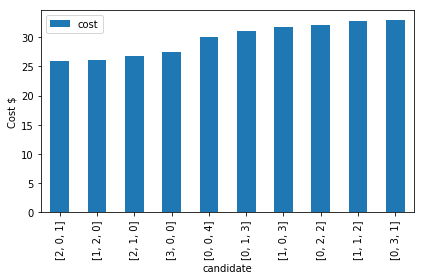

In [16]:
results[results.valid != False].sort_values('cost').head(10).plot(x='candidate', y='cost', kind='bar')
plt.ylabel('Cost $')
plt.tight_layout()
plt.show()